In [1]:
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.l2_functions import Function
import numpy as np
import matplotlib.pyplot as plt
from pygeoinf.interval.operators import LaplacianInverseOperator, LaplacianOperator
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.sobolev_space import Sobolev

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


In [2]:
function_domain = IntervalDomain(0, 1)
N = 30 # DOF of the discretized model space
basis_type = 'fourier'  # Specify basis type for Sobolev space
M = L2Space(N, function_domain, basis_type=basis_type) # Continuous model space
M_sobolev = Sobolev(N, function_domain, 2, 'spectral', basis_type=basis_type)
V_N = EuclideanSpace(N) # Parameter space

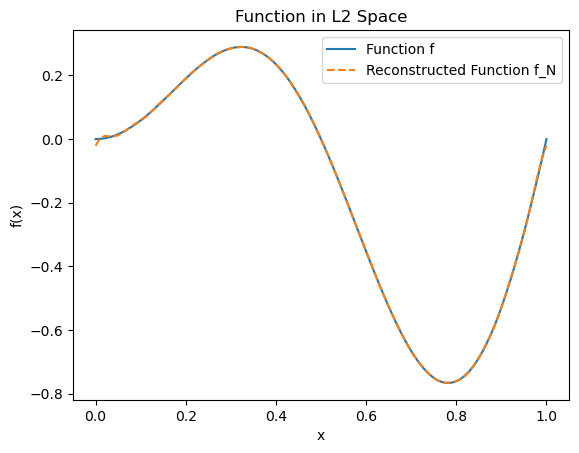

In [3]:
# Example of usage
f = Function(M, evaluate_callable=lambda x: x * np.sin(2 * np.pi * x))

alpha = M.to_components(f) # This is a member of the parameter space V_N
f_N = M.from_components(alpha) # This is a member of the continuous model space M

x = function_domain.uniform_mesh(100)
plt.plot(x, f(x), label='Function f')
plt.plot(x, f_N(x), label='Reconstructed Function f_N', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function in L2 Space')
plt.legend()

plt.show()

In [4]:
bcs = BoundaryConditions('dirichlet', left=0, right=0)
C_M = LaplacianInverseOperator(M, bcs)
M.create_gaussian_measure(method='kl', covariance=C_M, kl_expansion=10)

DOLFINx found but has compatibility issues, using native solver
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
